### This notebook will be exploring if we can predict the age of death from our data found [here](https://www.kaggle.com/cdc/mortality)

I will first try to predict the age of death from someone who would be *alive* using the below variables

---

*X_variables*
- resident_status
- education_2003_revision
- sex
- maritial_status
- race
- hispanic_origin
- hispanic_originrace_recode

*y_variable*
- detail_age

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import sys
import os

In [3]:
data_2005 = pd.read_csv('../data/2005_data.csv')

/home/jloesch30/miniconda3/envs/python3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (39,40,41,42,43,44,45,46,47,59,60,61,62,63,64,65,66) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
data_2005_revised = data_2005.drop(columns=['entity_condition_2', 'entity_condition_3', 'entity_condition_4',
       'entity_condition_5', 'entity_condition_6', 'entity_condition_7',
       'entity_condition_8', 'entity_condition_9', 'entity_condition_10',
       'entity_condition_11', 'entity_condition_12', 'entity_condition_13',
       'entity_condition_14', 'entity_condition_15', 'entity_condition_16',
       'entity_condition_17', 'entity_condition_18', 'entity_condition_19',
       'entity_condition_20', 'record_condition_2', 'record_condition_3',
       'record_condition_4', 'record_condition_5', 'record_condition_6',
       'record_condition_7', 'record_condition_8', 'record_condition_9',
       'record_condition_10', 'record_condition_11', 'record_condition_12',
       'record_condition_13', 'record_condition_14', 'record_condition_15',
       'record_condition_16', 'record_condition_17', 'record_condition_18',
       'record_condition_19', 'record_condition_20'])

In [5]:
# removing education 1989 education revised bc 2003 education revision has the most up to date information
try:
    data_2005_revised = data_2005_revised.drop(columns=['education_1989_revision'])
except:
    pass

# removing column for age_sub flag
try:
    data_2005_revised = data_2005_revised.drop(columns=['age_substitution_flag'])
except:
    pass

# remove infant age_recode
try:
    data_2005_revised = data_2005_revised.drop(columns=['infant_age_recode_22'])
except:
    pass

# remove place_of_injury_for_causes_w00_y34_except_y06_and_y07_
try:
    data_2005_revised = data_2005_revised.drop(columns=['place_of_injury_for_causes_w00_y34_except_y06_and_y07_'])
except:
    pass

# remove 130_infant_cause_recode
try:
    data_2005_revised = data_2005_revised.drop(columns=['130_infant_cause_recode'])
except:
    pass

# remove bridged race flag
try:
    data_2005_revised = data_2005_revised.drop(columns=['bridged_race_flag'])
except:
    pass

# Race imputation flag
try:
    data_2005_revised = data_2005_revised.drop(columns=['race_imputation_flag'])
except:
    pass

# replace NaN values with '9' for education column

data_2005_revised['education_2003_revision'] = data_2005_revised['education_2003_revision'].fillna(9)

# replace manner of death NaN values with 0 for "not specified"

data_2005_revised['manner_of_death'] = data_2005_revised['manner_of_death'].fillna(0)

# replace activity code with 10 for NaN values

data_2005_revised['activity_code'] = data_2005_revised['activity_code'].fillna(10)

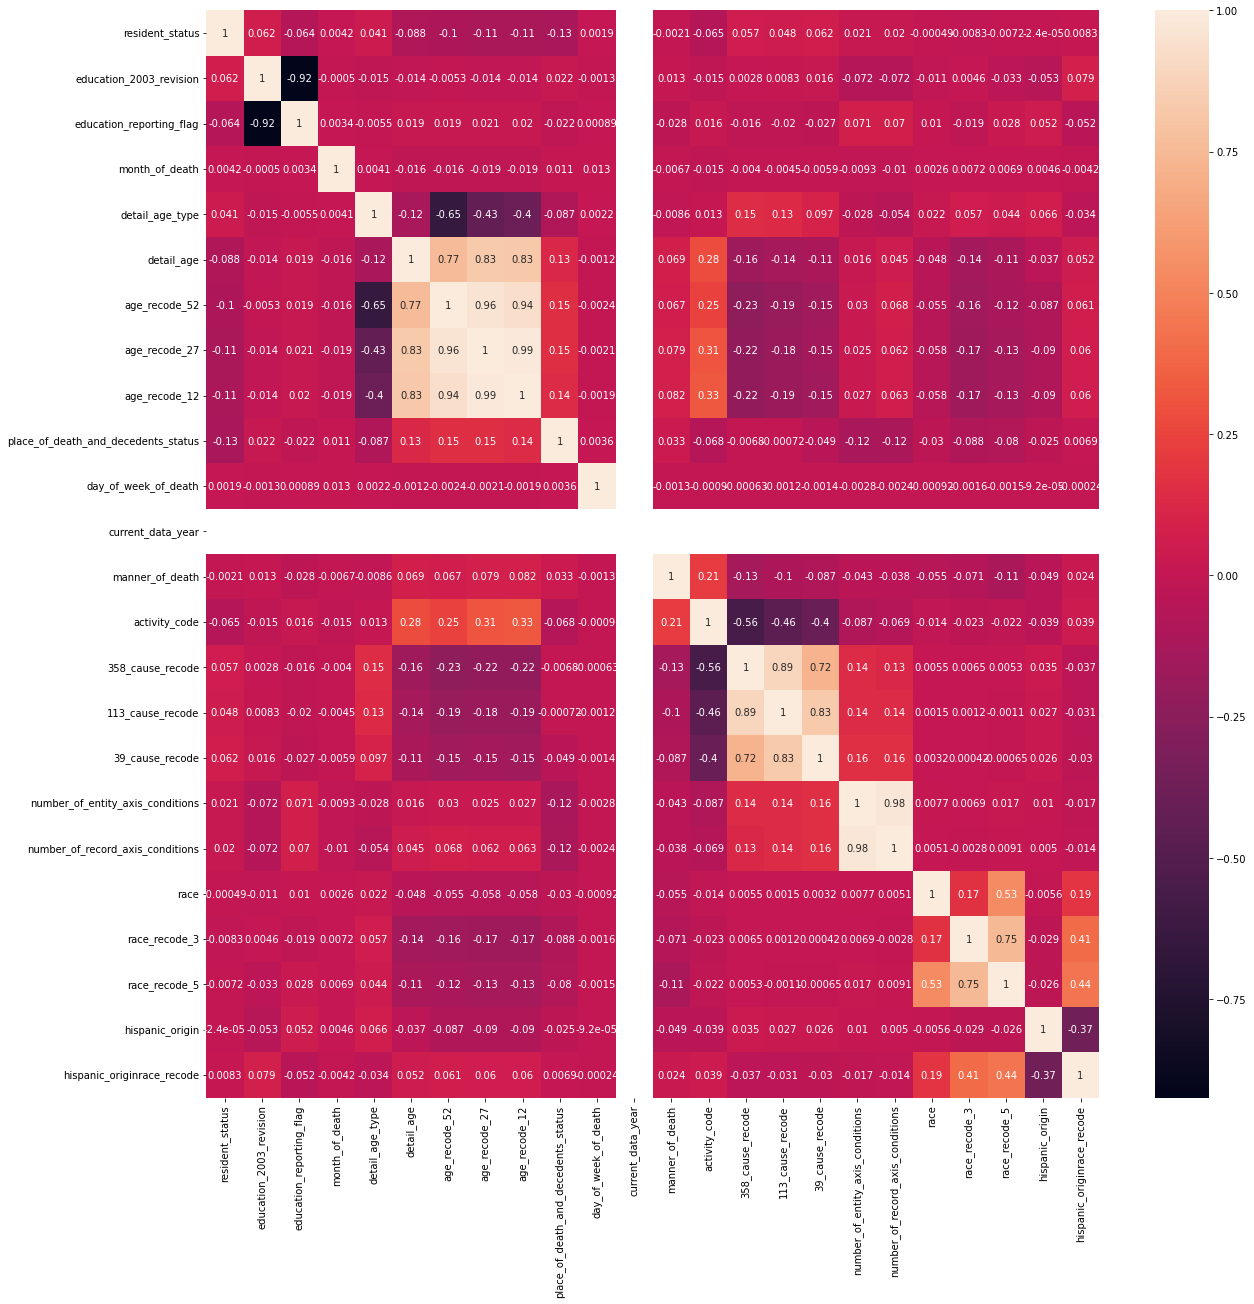

In [12]:
# printing correlation matrix between data

corrMatrix = data_2005_revised.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [6]:
# getting desired variables
'''
resident_status
education_2003_revision
sex
marital_status
race
hispanic_origin
hispanic_originrace_recode
'''

data_2005_revised = data_2005_revised[['resident_status', 'education_2003_revision', 'sex', 'marital_status', 'race', 'hispanic_origin', 'hispanic_originrace_recode', 'detail_age']]

In [7]:
data_2005_revised.head(3)

,resident_status,education_2003_revision,sex,marital_status,race,hispanic_origin,hispanic_originrace_recode,detail_age
0,1,9.0,F,M,1,100,6,45
1,1,9.0,M,D,1,100,6,61
2,1,9.0,F,D,1,100,6,79


In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data_2005_revised['detail_age'].value_counts())

84     78826
83     78189
85     77107
82     75457
81     74325
80     72270
86     71964
87     71247
79     68373
88     67525
78     65709
89     63723
77     62195
90     60295
76     57241
75     54752
91     54542
74     51276
92     48574
73     48464
72     44526
71     41701
93     41582
70     40602
69     37666
68     35643
67     34861
94     34821
66     32862
62     31972
65     31634
64     30983
63     30966
95     28995
58     28735
61     28165
57     26390
60     26131
59     24983
56     24433
55     23547
96     22983
54     22319
53     21722
52     21278
51     20024
50     19306
49     18232
97     18059
48     17071
47     15864
46     14798
45     13974
98     13191
44     12843
43     11767
42     10847
41      9639
99      9572
1       8820
40      8736
39      7637
38      6718
100     6692
37      6175
2       5850
36      5724
35      5605
34      5295
101     4749
33      4741
21      4572
32      4521
23      4424
22      4420
25      4369
24      4313

We can see that there are 405 values with missing ages, I am going to remove those

In [8]:
data_2005_revised = data_2005_revised[data_2005_revised['detail_age'] != 999]

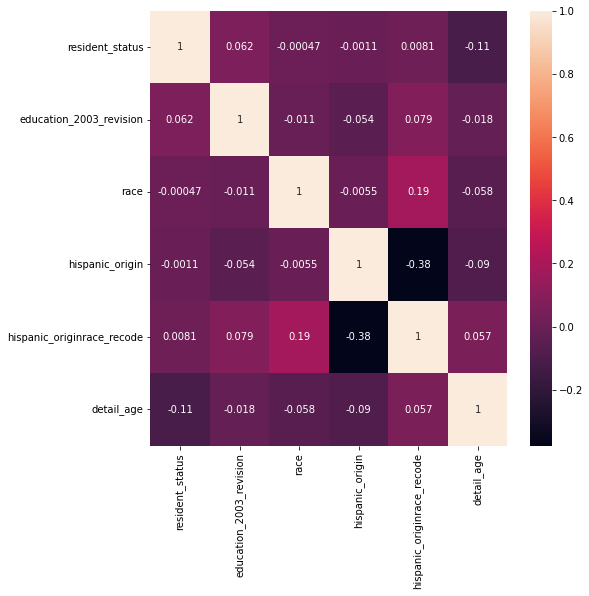

In [14]:
corrMatrix = data_2005_revised.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corrMatrix, annot=True)
plt.show()

## CatboostRegressor model testing
Predicting the age of someone alive of which they will die\
using the regressor since we are predicting a continuos label now

In [27]:
data_2005_revised = data_2005_revised.astype({'education_2003_revision': 'int64'})

In [28]:
data_2005_revised.head()

,resident_status,education_2003_revision,sex,marital_status,race,hispanic_origin,hispanic_originrace_recode,detail_age
0,1,9,F,M,1,100,6,45
1,1,9,M,D,1,100,6,61
2,1,9,F,D,1,100,6,79
3,1,9,M,S,1,100,6,50
4,1,9,F,M,1,100,6,68


In [29]:
data_2005_revised_cat = data_2005_revised.astype({'resident_status': 'category', 'education_2003_revision': 'category',
                                                 'sex': 'category', 'marital_status': 'category', 'race': 'category',
                                                 'hispanic_origin': 'category', 'hispanic_originrace_recode': 'category'})

In [30]:
data_2005_revised_cat.dtypes

resident_status               category
education_2003_revision       category
sex                           category
marital_status                category
race                          category
hispanic_origin               category
hispanic_originrace_recode    category
detail_age                       int64
dtype: object

In [31]:
X = data_2005_revised_cat[['resident_status', 'education_2003_revision',
                                                 'sex', 'marital_status', 'race',
                                                 'hispanic_origin', 'hispanic_originrace_recode']]
y = data_2005_revised_cat['detail_age']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

In [32]:
X_train.head()

,resident_status,education_2003_revision,sex,marital_status,race,hispanic_origin,hispanic_originrace_recode
1293713,1,9,F,W,1,100,6
1262286,1,9,M,W,1,100,6
280452,1,2,F,W,1,100,6
168741,1,4,M,W,1,100,6
89690,1,9,M,M,1,100,6


In [41]:
import catboost as cb

cat_variables = list(X_train.columns)

train_dataset = cb.Pool(X_train, y_train, cat_features=cat_variables)
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_variables)

model = cb.CatBoostRegressor(loss_function='RMSE', iterations=300, verbose=False)

In [42]:
model.fit(train_dataset)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [46]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print("Testing performance")
print("RMSE: {:.2f}".format(rmse))
print("R-Squared: {:.2f}".format(r2))

Testing performance
RMSE: 14.20
R-Squared: 0.42


This model preformed  bad, it tells us that our data is not beig processed correctly or the features we chose
do not describe the age of death